In [ ]:
!git clone https://github.com/KuzmaKhrabrov/character-tokenizer.git

In [ ]:
!pip install transformers

# Tokenizer

In [53]:
import string
import sys
sys.path.append("/kaggle/input/hw10-transformers/charactertokenizer")
from charactertokenizer import CharacterTokenizer

chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя"
model_max_length = 58
tokenizer = CharacterTokenizer(chars, model_max_length)

In [54]:
example = "Проверка2"
accent = "Проверк^а2"
tokens = tokenizer(example, accent)
print(tokens)

{'input_ids': [0, 39, 42, 38, 12, 18, 42, 30, 8, 6, 1, 39, 42, 38, 12, 18, 42, 30, 6, 8, 6, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [55]:
tokenizer # Проверить макс число токенов

CharacterTokenizer(name_or_path='', vocab_size=73, model_max_length=58, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[BOS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("[BOS]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
	4: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	6: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [56]:
tokens = tokenizer(
    example,        
    max_length=58, 
    padding="max_length", 
    truncation=True, 
    return_tensors="pt"
)
tokens

{'input_ids': tensor([[ 0, 39, 42, 38, 12, 18, 42, 30,  8,  6,  1,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

Задание: обучите модель классификации букв для задачи расстановки ударения с помощью методов из библиотеки transformers. Датасет для обучения можно взять отсюда: https://github.com/Koziev/NLP_Datasets/blob/master/Stress/all_accents.zip

1. Напишите класс для Dataset/Dataloder и разбейте данные на случайные train / test сплиты в соотношении 50:50. (1 балл)
2. Попробуйте обучить одну или несколько из моделей: Bert, Albert, Deberta. Посчитайте метрику Accuracy на train и test. (1 балл). При преодолении порога в Accuracy на test 0.8: (+1 балл), 0.85: (+2 балла), 0.89: (+3 балла).
Пример конфигурации для deberta: https://huggingface.co/IlyaGusev/ru-word-stress-transformer/blob/main/config.json

# Подготовка данных

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from charactertokenizer import CharacterTokenizer

In [58]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [59]:
data_path = "/kaggle/input/hw10-transformers/all_accents/all_accents.tsv"
df = pd.read_csv(data_path, sep='\t', header=None, names=['original', 'accented'])

# Фильтрация и создание столбца 'label'
df['label'] = df['accented'].str.find('^')

# Отфильтровать строки, где 'label' не равен -1
df_filtered = df[df['label'] != -1]

# Разделение данных на train и test
train_df, test_df = train_test_split(df_filtered, test_size=0.5, random_state=42)

In [ ]:
df_filtered = df_filtered.head(20000)
train_df, test_df = train_test_split(df_filtered, test_size=0.5, random_state=42)

In [60]:
df_filtered.shape, df.shape

((1680028, 3), (1680535, 3))

In [61]:
train_df.head()

,original,accented,label
909760,отображенною,отображ^енною,7
161644,вклиненном,вкл^иненном,3
795740,нормализовавшийся,нормализов^авшийся,10
283731,гравлин,гравл^ин,5
405519,законтрактовываетесь,законтракт^овываетесь,10


In [62]:
max_len = 0

# For every sentence...
for index, row in df.iterrows():
    input_len = row['original']
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_len))

print('Max sentence length: ', max_len) # 58

Max sentence length:  56


In [ ]:
class AccentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        original_text = self.dataframe.iloc[idx]['original']
        accent_idx = self.dataframe.iloc[idx]['label']
        
        labels = torch.zeros(self.max_length, dtype=torch.long)
        # +1 because we have cls token at first
        labels[accent_idx + 1] = 1
        
        encoding = self.tokenizer(
            original_text, 
            max_length=self.max_length, 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt"
        )
        encoding['input_ids'] = encoding['input_ids'].flatten()
        
#         encoding['input_ids'][0] = -100  # cls
#         encoding['input_ids'][-1] = -100  # sep
#         encoding['input_ids'][len(original_text) + 1:-1] = -100 # pad

        return {
            'input_ids': encoding['input_ids'].long(),
            'attention_mask': encoding['attention_mask'].flatten().long(),
            'labels': labels,
        }

In [64]:
chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя"
model_max_length = 58
tokenizer = CharacterTokenizer(chars, model_max_length)

# Создание экземпляров AccentDataset для train и test
train_dataset = AccentDataset(train_df, tokenizer, model_max_length)
test_dataset = AccentDataset(test_df, tokenizer, model_max_length)

# Создание DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [65]:
tmp = next(iter(train_dataloader))

In [66]:
tmp['labels'].shape, tmp['input_ids'].shape, tmp['attention_mask'].shape

(torch.Size([64, 58]), torch.Size([64, 58]), torch.Size([64, 58]))

In [67]:
tmp = train_dataset[2]
tmp

{'input_ids': tensor([ 0, 36, 38, 42, 34,  8, 32, 26, 24, 38, 12,  8, 12, 58, 26, 28, 44, 72,
          1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

# Prepare Model 

In [ ]:
# Version 0
# Validation Loss: 0.0176
# Accuracy: 0.9922
# Accent Accuracy: 0.7175
# Precision: 0.8074
# Recall: 0.7202
# F1-score: 0.7613

config_dict = {
  "architectures": [
    "DebertaV2ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.2, # default 0.1
  "hidden_act": "gelu", # default gelu
  "hidden_dropout_prob": 0.2, # default 0.1
  "hidden_size": 256, # default 1536
#   "id2label": {
#     "0": "NO",
#     "1": "YES",
#   },
  "initializer_range": 0.02, # defaults 0.02
  "intermediate_size": 1024, # defaults 6144
#   "label2id": {
#     "NO": 0,
#     "YES": 1,
#   },
  "layer_norm_eps": 1e-07, # defaults 1e-07
#   "max_length": 58,
  "max_position_embeddings": 58, # defaults 512
  "max_relative_positions": 58, # defaults to -1
  "model_type": "deberta-v2",
  "num_attention_heads": 8, # defaults to 24
  "num_hidden_layers": 4, # defaults to 24
  "pad_token_id": 0, # default 0
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 256,
  "pos_att_type": None, # defeault None 
  "position_biased_input": True, # default False
  "relative_attention": True, # default True
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 0, # defaults to 0
  "vocab_size": 128100
}

In [ ]:
# Version 1
# Validation Loss: 0.0224
# Accuracy: 0.9898
# Accent Accuracy: 0.5913
# Precision: 0.7623
# Recall: 0.5928
# F1-score: 0.6669
config_dict = {
  "architectures": [
    "DebertaV2ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.2, # default 0.1
  "hidden_act": "gelu", # default gelu
  "hidden_dropout_prob": 0.2, # default 0.1
  "hidden_size": 256, # default 1536
  "initializer_range": 0.02, # defaults 0.02
  "intermediate_size": 1024, # defaults 6144
  "layer_norm_eps": 1e-07, # defaults 1e-07
  "max_length": 58,
  "max_position_embeddings": 58, # defaults 512
  "max_relative_positions": 58, # defaults to -1
  "model_type": "deberta-v2",
  "num_attention_heads": 16, # defaults to 24
  "num_hidden_layers": 4, # defaults to 24
  "pad_token_id": 0, # default 0
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 256,
  "pos_att_type": None, # defeault None 
  "position_biased_input": True, # default False
  "relative_attention": True, # default True
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 0, # defaults to 0
  "vocab_size": tokenizer.vocab_size
}

In [ ]:
# Version 2
# Validation Loss: 0.0160
# Accuracy: 0.9930
# Accent Accuracy: 0.7622
# Precision: 0.8185
# Recall: 0.7665
# F1-score: 0.7917
config_dict = {
  "architectures": [
    "DebertaV2ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.2, # default 0.1
  "hidden_act": "gelu", # default gelu
  "hidden_dropout_prob": 0.2, # default 0.1
  "hidden_size": 1024, # default 1536
  "initializer_range": 0.02, # defaults 0.02
  "intermediate_size": 1024, # defaults 6144
  "layer_norm_eps": 1e-08, # defaults 1e-07
  "max_length": 58,
  "max_position_embeddings": 58, # defaults 512
  "max_relative_positions": 58, # defaults to -1
  "model_type": "deberta-v2",
  "num_attention_heads": 16, # defaults to 24
  "num_hidden_layers": 4, # defaults to 24
  "pad_token_id": 0, # default 0
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": None, # defeault None 
  "position_biased_input": True, # default False
  "relative_attention": True, # default True
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 0, # defaults to 0
  "vocab_size": tokenizer.vocab_size
}

In [ ]:
# Version 3 -> 36
config_dict = {
  "architectures": [
    "DebertaV2ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.2, # default 0.1
  "hidden_act": "gelu", # default gelu
  "hidden_dropout_prob": 0.2, # default 0.1
  "hidden_size": 1536, # default 1536
  "initializer_range": 0.02, # defaults 0.02
  "intermediate_size": 1536, # defaults 6144
  "layer_norm_eps": 1e-08, # defaults 1e-07
  "max_length": 58,
  "max_position_embeddings": 58, # defaults 512
  "max_relative_positions": 58, # defaults to -1
  "model_type": "deberta-v2",
  "num_attention_heads": 12, # defaults to 24
  "num_hidden_layers": 4, # defaults to 24
  "pad_token_id": 0, # default 0
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1536,
  "pos_att_type": None, # defeault None 
  "position_biased_input": True, # default False
  "relative_attention": True, # default True
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 0, # defaults to 0
  "vocab_size": tokenizer.vocab_size
}

In [ ]:
# Version 4 -> 51
# Validation Loss: 0.0109
# Accuracy: 0.9955
# Accent Accuracy: 0.8495
# Precision: 0.8771
# Recall: 0.8606
# F1-score: 0.8688
config_dict = {
  "architectures": [
    "DebertaV2ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1, # default 0.1
  "hidden_act": "gelu", # default gelu
  "hidden_dropout_prob": 0.1, # default 0.1
  "hidden_size": 1800, # default 1536
  "initializer_range": 0.02, # defaults 0.02
  "intermediate_size": 2048, # defaults 6144
  "layer_norm_eps": 1e-08, # defaults 1e-07
  "max_length": 58,
  "max_position_embeddings": 58, # defaults 512
  "max_relative_positions": 58, # defaults to -1
  "model_type": "deberta-v2",
  "num_attention_heads": 10, # defaults to 24
  "num_hidden_layers": 4, # defaults to 24
  "pad_token_id": 0, # default 0
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1800,
  "pos_att_type": None, # defeault None 
  "position_biased_input": True, # default False
  "relative_attention": True, # default True
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 0, # defaults to 0
  "vocab_size": tokenizer.vocab_size
}

In [ ]:
from transformers import DebertaV2ForTokenClassification, DebertaForTokenClassification, DebertaConfig, BertForTokenClassification

config = DebertaConfig.from_dict(config_dict)
# model = DebertaForTokenClassification(config)
model = DebertaV2ForTokenClassification(config)

# model = BertForTokenClassification(
#     "bert-base-multilingual-uncased",  # Используйте 12-слойную модель BERT с некэйсовым словарем.
#     num_labels=2,  # В данном случае 2 класса: 0 и 1 (акцент / нет акцента).
#     output_attentions=False,  
#     output_hidden_states=False,
# )


# model_name = "microsoft/deberta-base"
# model = DebertaForTokenClassification.from_pretrained(model_name, num_labels=2)

print(True)

# Train model

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Ваш код для создания модели и загрузки данных

# Определение функции обучения
def train_epoch(model, train_dataloader, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_dataloader, desc="Training"):
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

#         import pdb; pdb.set_trace()
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def validate(model, val_dataloader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct_accent_predictions = 0

    # Заведем счетчики для подсчета метрик
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Подсчет accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=2)

            # Подсчет верно угаданных ударений
            correct_accent_predictions += (np.all(predictions.cpu().numpy() == labels.cpu().numpy(), axis=1)).sum() / labels.shape[0]

            # Обновление счетчиков для подсчета precision, recall и f1-score
            true_positives += np.sum(np.logical_and(predictions.cpu().numpy() == 1, labels.cpu().numpy() == 1))
            true_negatives += np.sum(np.logical_and(predictions.cpu().numpy() == 0, labels.cpu().numpy() == 0))
            false_positives += np.sum(np.logical_and(predictions.cpu().numpy() == 1, labels.cpu().numpy() == 0))
            false_negatives += np.sum(np.logical_and(predictions.cpu().numpy() == 0, labels.cpu().numpy() == 1))

            total_samples += torch.numel(labels)

    avg_loss = total_loss / len(val_dataloader)

    # Расчет метрик
    accuracy = (true_positives + true_negatives) / total_samples
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accent_accuracy = correct_accent_predictions / len(val_dataloader)

    return avg_loss, accuracy, accent_accuracy, precision, recall, f1

In [ ]:
from transformers import AdamW
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# Параметры обучения
epochs = 3

# Создание оптимизатора и функции потерь
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# Перенос модели на GPU
model.to(device)

# Цикл обучения
for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, device)
    val_loss, val_accuracy, val_accent_accuracy, val_precision, val_recall, val_f1 = validate(model, test_dataloader, device)

    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Accuracy: {val_accuracy:.4f}')
    print(f'Accent Accuracy: {val_accent_accuracy:.4f}')
    print(f'Precision: {val_precision:.4f}')
    print(f'Recall: {val_recall:.4f}')
    print(f'F1-score: {val_f1:.4f}')
    
    model_save_path = "/kaggle/working/tmp_debertaV2"
    model.save_pretrained(model_save_path)
    
model_save_path = "/kaggle/working/debertaV2"
model.save_pretrained(model_save_path)

### На самом деле сверху обучена модель на 4 эпохах, первую эпоху сохранял ранее и начинал обучение с дозагрузкой. 
### Но Kaggle крашнулся, и сохранить вывод я смог только скриншотом снизу.

### Но финальную валидацию я могу провести, так как смог сохранить параметры модели через код в самом конце ноутбука. У меня просто не сохранялась версия, и я не мог скачать Jupyter ноутбук, kaggle запрещал, выдавая ошибки.

### Полученный score предсказания 92.8% (виден в валидации снизу + на скриншотах)

In [88]:
val_loss, val_accuracy, val_accent_accuracy, val_precision, val_recall, val_f1 = validate(model, test_dataloader, device)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Accuracy: {val_accuracy:.4f}')
print(f'Accent Accuracy: {val_accent_accuracy:.4f}')
print(f'Precision: {val_precision:.4f}')
print(f'Recall: {val_recall:.4f}')
print(f'F1-score: {val_f1:.4f}')

Validation: 100%|██████████| 13126/13126 [28:06<00:00,  7.78it/s]

Validation Loss: 0.0054
Accuracy: 0.9979
Accent Accuracy: 0.9280
Precision: 0.9465
Recall: 0.9319
F1-score: 0.9392


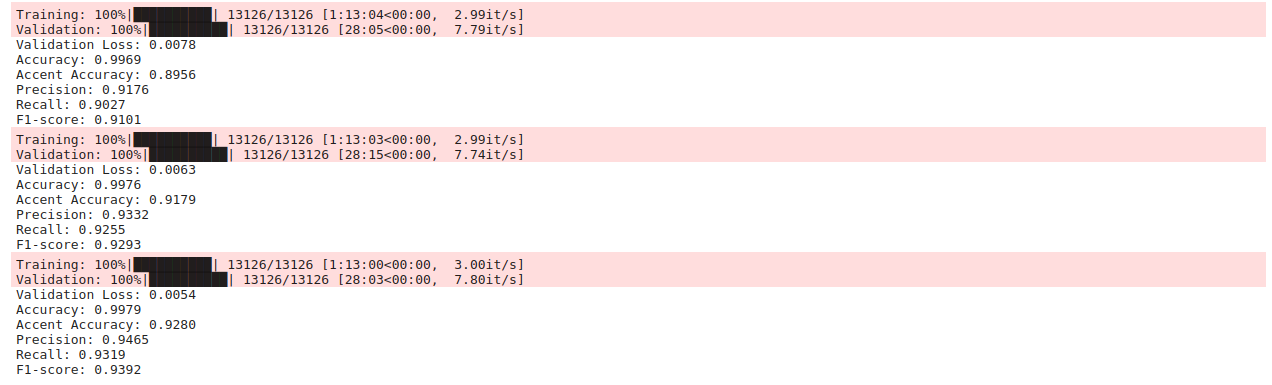

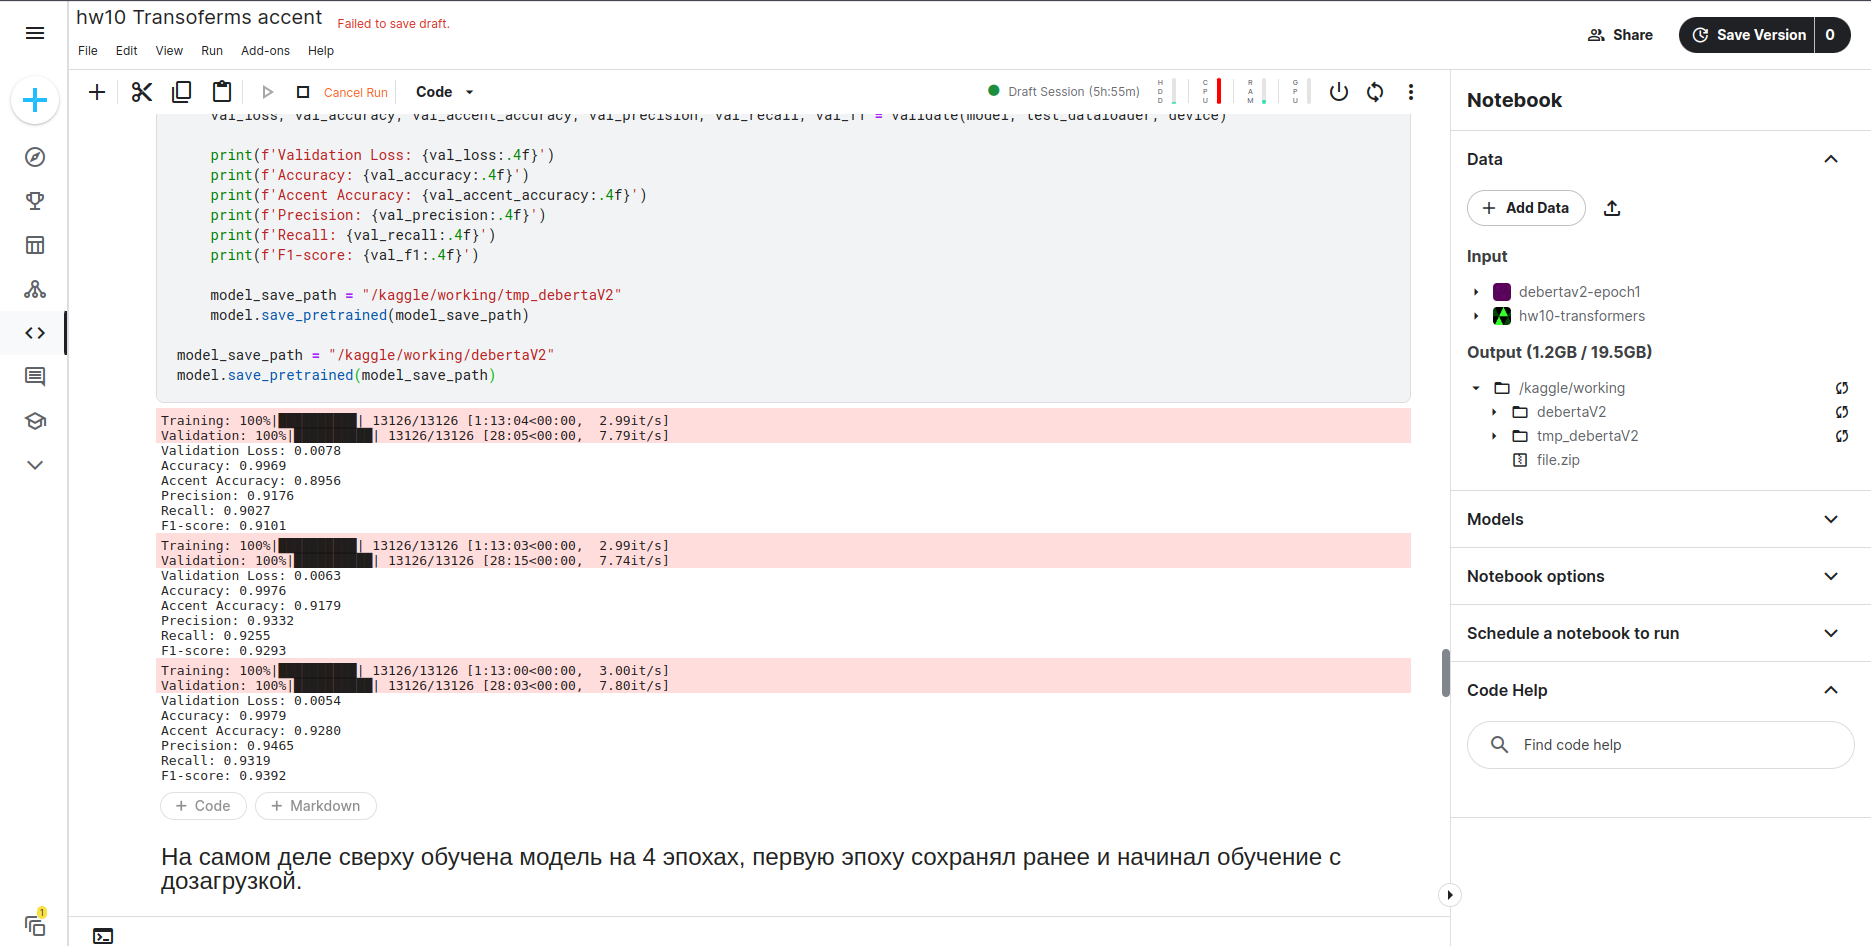

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def validate_more(model, val_dataloader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    true_labels = []
    predicted_labels = []
    correct_accent_predictions = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Подсчет accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=2)

            true_labels.extend(labels.cpu().numpy().flatten())
            predicted_labels.extend(predictions.cpu().numpy().flatten())

            # Добавление информации о верных/неверных предсказаниях ударения
            correct_accent_predictions += (np.all(predictions.cpu().numpy() == labels.cpu().numpy(), axis=1)).sum() / labels.shape[0]

    avg_loss = total_loss / len(val_dataloader)

    # Преобразование списков в numpy array
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    correct_accent_predictions = np.array(correct_accent_predictions)

    # Расчет метрик
    precision = precision_score(true_labels, predicted_labels, average='binary', pos_label=1)
    recall = recall_score(true_labels, predicted_labels, average='binary', pos_label=1)
    f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(true_labels, predicted_labels)
    accent_accuracy = correct_accent_predictions / len(val_dataloader)

    print(f'Validation Loss: {avg_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Accent Accuracy: {accent_accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    return avg_loss, accuracy, accent_accuracy


In [52]:
# model.to(device)

small_df = df_filtered.head(10000) 
small_dataset = AccentDataset(small_df, tokenizer, model_max_length)

small_dataloader = DataLoader(small_dataset, batch_size=32, shuffle=False)
# val_loss, val_accuracy, val_accent_accuracy, val_precision, val_recall, val_f1 = validate(model, test_dataloader, device)
val_loss, val_accuracy, val_accent_accuracy, val_precision, val_recall, val_f1 = validate(model, small_dataloader, device)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Accuracy: {val_accuracy:.4f}')
print(f'Accent Accuracy: {val_accent_accuracy:.4f}')
print(f'Precision: {val_precision:.4f}')
print(f'Recall: {val_recall:.4f}')
print(f'F1-score: {val_f1:.4f}')

Validation: 100%|██████████| 313/313 [00:20<00:00, 15.13it/s]

Validation Loss: 0.0058
Accuracy: 0.9979
Accent Accuracy: 0.9264
Precision: 0.9457
Recall: 0.9309
F1-score: 0.9383


In [ ]:
model_save_path = "/kaggle/working/deberta"
model.save_pretrained(model_save_path)

# Thats END

# Some testing

In [84]:
# model_load_path = "/kaggle/working/debertaV2"
# model_load_path = "/kaggle/input/debertav2-epoch1"
model_load_path = "/kaggle/input/debertav2/debertaV2/debertaV2_4_epochs"
loaded_model = DebertaV2ForTokenClassification.from_pretrained(model_load_path)
loaded_model.eval()
loaded_model.to(device)
print(True)

True


In [ ]:
def get_accented(example, model=model, tokenizer=tokenizer, model_max_length=model_max_length, device=device):
    encoding = tokenizer(
        example, 
        max_length=model_max_length, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    )

    input_ids = encoding['input_ids'].flatten().to(device)
    attention_mask = encoding['attention_mask'].flatten().to(device)

    # Добавим измерение "батча"
    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2)

    accent_indices = torch.nonzero(predictions.flatten() == 1).flatten().tolist()
    result = ['cls'] + list(example) + ['end']
    for index in accent_indices:
        result[index] = result[index].upper()

    result = "".join(result[1:-1])

    return result

In [86]:
# model = loaded_model
model.eval()

originals = [
    'привет', 
    'тимофей', 
    'айфон',
    'компьютер',
    'функция',
    'гипертекст',
    'свадьба',
    'француз',
    'абрикос',
]

print("======== Слово - Ударение ========\n")
for original in originals:
    accented = get_accented(original, model=loaded_model)
    print(f"\t{original} - {accented}")

======== Слово - Ударение ========

	привет - привЕт
	тимофей - тимофЕй
	айфон - айфОн
	компьютер - компьЮтер
	функция - фУнкция
	гипертекст - гипертЕкст
	свадьба - свАдьба
	француз - францУз
	абрикос - абрикОс


## А что выдаст необученная модель

In [87]:
not_train_model = DebertaV2ForTokenClassification(config)

print("======== Слово - Ударение ========\n")
for original in originals:
    accented = get_accented(original, model=not_train_model, device='cpu')
    print(f"\t{original} - {accented}")

======== Слово - Ударение ========

	привет - пРИВеТ
	тимофей - тиМофей
	айфон - АЙфон
	компьютер - компьютер
	функция - фУнкцИя
	гипертекст - гиперТекст
	свадьба - сВадьБа
	француз - фРАнцуз
	абрикос - абрикОс


# Как видно, модель реально обучилась хорошо предсказывать ударения

In [ ]:
# kaggle крашнул ноутбук, не дает сохранить версию, скачать его, поэтому просто скачаю файл вручную с моделями и добавлю в новый датасет 
!zip -r file.zip /kaggle/working

In [ ]:
!ls
from IPython.display import FileLink
FileLink(r'file.zip')